In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torchvision.io import read_image
from PIL import Image


In [2]:
import cv2
img_original = cv2.imread('./images/Cat03.jpg')[:,:,::-1]
print(img_original.shape)
res = img_original.shape
#plt.imshow(img_original)
#plt.axis('off')

def get_warped_crop(img, corners, res=(1024, 1024)):
    input_pts = np.float32(corners)
    output_pts = np.float32([[0, 0], [0, res[0] - 1], [res[1] - 1, res[0] -1], [res[1] - 1, 0]])
    # Compute the perspective transform M
    M = cv2.getPerspectiveTransform(input_pts,output_pts)
    out = cv2.warpPerspective(img, M, (res[0], res[1]),flags=cv2.INTER_LINEAR)
    return out, M

corners0 = np.float32([[100, 100], [100, 1000], [800, 1000], [800, 100]])
warped_img0, M0 = get_warped_crop(img_original, corners0)

corners1 =  np.float32([[400, 100], [400, 1000], [1100, 1000], [1100, 100]])
warped_img1, M1 = get_warped_crop(img_original, corners1)


(1199, 1200, 3)


[[ 1.46142857e+00 -0.00000000e+00 -1.46142857e+02]
 [-1.29420284e-16  1.13666667e+00 -1.13666667e+02]
 [-3.96895817e-20  0.00000000e+00  1.00000000e+00]]


(-0.5, 1023.5, 1023.5, -0.5)

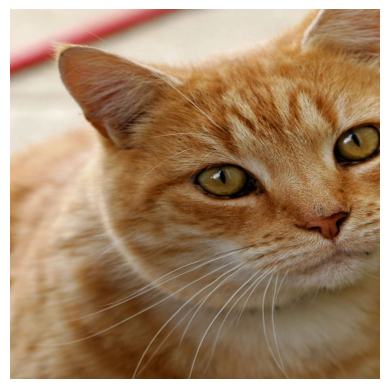

In [3]:
print(M0)
plt.imshow(warped_img0)
plt.axis('off')

[[ 1.46142857e+00 -0.00000000e+00 -5.84571429e+02]
 [ 3.50657454e-17  1.13666667e+00 -1.13666667e+02]
 [-7.93791633e-20  0.00000000e+00  1.00000000e+00]]


(-0.5, 1023.5, 1023.5, -0.5)

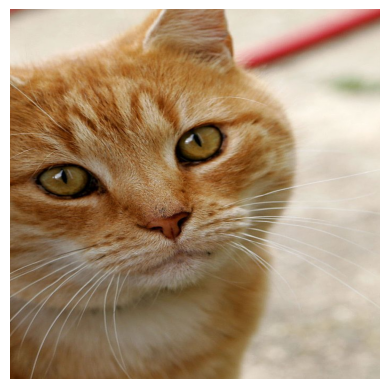

In [4]:
print(M1)
plt.imshow(warped_img1)
plt.axis('off')

In [5]:
device = 'cpu'


img0 = torch.tensor(warped_img0.transpose((2, 0, 1))).to(device).float() / 255.0
img1 = torch.tensor(warped_img1.transpose((2, 0, 1))).to(device).float() / 255.0

img = torch.stack([img0, img1], dim=0)
img_size = torch.tensor( (img.shape[3], img.shape[2])).to(device)
print(img.shape)

torch.Size([2, 3, 1024, 1024])


In [6]:
# get a batch of random (x, y) points within the unit square
# return the point cordinates and the target RGB values for each point
# return shape (nbatch, 3), (nbatch, 2)
def get_samples(img, nbatch=1024):
    iy = torch.randint(0, img.shape[1], (nbatch, ), device=device)
    ix = torch.randint(0, img.shape[2], (nbatch, ), device=device)
    x = torch.stack([ix, iy], dim=1)
    xnorm = x / img_size
    target_rgb = img[:, iy, ix].T
    return target_rgb, xnorm

In [7]:
# evaluate the model on a grid of points of size (Ny, Nx) to generate an image
# return the image as an np array of shape (Ny, Nx, 3)
def eval_image(model, Ny, Nx, device='cpu', crop=None, idx=None, num_levels=None):
    yy, xx = torch.meshgrid(torch.arange(Ny), torch.arange(Nx), indexing='ij')
    xpts = torch.stack([xx.flatten(), yy.flatten()], dim=1).to(device)
    xnorm = xpts / torch.tensor([Nx, Ny], device=device)
    if crop is not None:
        xnorm[:, 0] *= (crop[2] - crop[0])
        xnorm[:, 0] += crop[0]
        xnorm[:, 1] *= (crop[3] - crop[1])
        xnorm[:, 1] += crop[1]
    rgb = model(xnorm, idx=idx, num_levels=num_levels)
    colors = rgb.detach().cpu().numpy()
    colors = np.clip(colors, 0, 1.0) * 255
    colors = colors.astype(np.uint8)
    colors = colors.reshape(Ny, Nx, -1)
    plt.imshow(colors)
    plt.axis('off')
    return colors

In [8]:
class HashEncoding(nn.Module):
    def __init__(self, Nmax, T, F):
        super().__init__()
        self.F = F
        self.Nmax = Nmax
        # if T > Nmax**2 then the embedding table is larger than it needs to be and the hashing is not needed
        self.use_hash = (T < Nmax**2)
        self.T = min(T, Nmax**2)
        self.embedding = nn.Embedding(self.T, F)
        nn.init.uniform_(self.embedding.weight, -0.1, 0.1)
    
    def _get_feature_vector(self, ix, iy):
        if self.use_hash:
            pi_1 = 2654435761
            hash_idx = torch.bitwise_xor(ix, iy * pi_1)
            hash_idx = torch.remainder(hash_idx, self.T)
        else:
            hash_idx = ix * self.Nmax + iy
            hash_idx = torch.remainder(hash_idx, self.T)
        return self.embedding(hash_idx) # shape (nbatch, F)
    
    def forward(self, xpts):
        xpts_scaled = xpts * self.Nmax
        corner_pt = xpts_scaled.floor()
        delta = xpts_scaled - corner_pt # offset from the upper left (between 0 and 1), shape (nbatch, 2)
        corner_idx = corner_pt.long()  # index of upper left corner
        # get feature vector associated with each of the 4 corners
        fv_ul = self._get_feature_vector(corner_idx[:, 0], corner_idx[:, 1])
        fv_ur = self._get_feature_vector(corner_idx[:, 0] + 1, corner_idx[:, 1])
        fv_ll = self._get_feature_vector(corner_idx[:, 0], corner_idx[:, 1] + 1)
        fv_lr = self._get_feature_vector(corner_idx[:, 0] + 1, corner_idx[:, 1] + 1)
        xfrac = delta[:, [0]]
        yfrac = delta[:, [1]]
        # bilinear interpolation of the feature vectors associated with the four corners of the cell
        fv_interp1 = xfrac * fv_lr + (1.0 - xfrac) * fv_ll
        fv_interp2 = xfrac * fv_ur + (1.0 - xfrac) * fv_ul
        fv_interp3 = yfrac * fv_interp1 + (1.0 - yfrac) * fv_interp2
        return fv_interp3
    
    
class MultiResolutionHashEncoding(nn.Module):
    def __init__(self, Nls, T, F, num_images=1):
        super().__init__()
        self.T = T
        self.F = F
        self.Nls = Nls
        self.L = len(Nls)
        M = torch.tensor([[1., 0.], [0., 1.]])
        M2 = torch.stack([M] * num_images, dim=0)
        b = torch.tensor([0., 0.])
        b2 = torch.stack([b] * num_images, dim=0)
    
        
        self.M_trans = nn.Parameter(M2)
        self.b_trans = nn.Parameter(b2)
        self.hash_encodings = nn.ModuleList()
        self.mlp = nn.Sequential(
            nn.Linear(self.L * self.F, 64),
             nn.ReLU(),
             nn.Linear(64, 64),
             nn.ReLU(),
             nn.Linear(64, 3))
        
        for Nl in Nls:
            he = HashEncoding(Nl, T, F)
            self.hash_encodings.append(he)
        
    def forward(self, xpts, num_levels=None, idx=None):
        if idx is not None:
            xpts_trans = xpts @ self.M_trans[idx] + self.b_trans[idx]
        else:
            xpts_trans = xpts
        # each level will output a tensor of shape (nbatch, F).  They will be concatenated into a tensor of shape (nbatch, L * F)
        feature_vector = torch.cat([he(xpts_trans) for he in self.hash_encodings], dim=1)  # (nbatch, L * F)
        if num_levels is not None and num_levels < self.L:
            feature_vector[:, num_levels * self.F:] = 0
        # The MLP will map (nbatch, L * F) feature vector to (nbatch, 3) RGB values for each sample
        rgb = self.mlp(feature_vector)
        return rgb
        

In [54]:
# using the same notation as the paper
b = 1.5             # grid size ratio
L = 4              # number of levels
Nmin = 16           # number of cells (in each dimension) of the coarsest level
T = 2 ** 15         # number of hash table entries per level
F = 2               # dimension of each feature vector

# number of cells (in each dimension) for each level
Nls = np.floor(Nmin * (b ** np.arange(0, L))).astype(int)
print(Nls)

mrhe = MultiResolutionHashEncoding(Nls, T, F, num_images=2).to(device)

num_params = sum([p.numel() for p in mrhe.parameters()])
num_bytes = img.numel()
ratio = 4 * num_params / num_bytes
print(f'{ratio=}')

# number of cells over number of entries in hash table for each level
hash_ratio = Nls**2 / T

[16 24 36 54]
ratio=0.009556452433268229


In [55]:
optim = torch.optim.Adam(params=mrhe.parameters(), eps=1e-15, lr=0.01)

In [56]:
num_levels = 1
for i in range(1, 10001):
    optim.zero_grad()
    target_rgb0, xnorm = get_samples(img[0], nbatch=2048)
    pred_rgb0 = mrhe(xnorm, num_levels=num_levels, idx=0)
    loss = torch.mean((target_rgb0 - pred_rgb0) ** 2)

    target_rgb1, xnorm = get_samples(img[1], nbatch=2048)
    pred_rgb1 = mrhe(xnorm, num_levels=num_levels, idx=1)
    loss += torch.mean((target_rgb1 - pred_rgb1) ** 2)

    loss.backward()
    optim.step()
    if i % 1000 == 0:
        mse = loss.item()
        psnr = -10 * np.log10(mse)
        print(f'{i}, {mse=:.05f}, {psnr=:.01f}')
    
    if i % 3000 == 0:
        num_levels += 1
        num_levels = min(num_levels, L)
        print(f'num_levels = {num_levels}')

1000, mse=0.00956, psnr=20.2
2000, mse=0.00917, psnr=20.4
3000, mse=0.00878, psnr=20.6
num_levels = 2
4000, mse=0.00575, psnr=22.4
5000, mse=0.00619, psnr=22.1
6000, mse=0.00502, psnr=23.0
num_levels = 3
7000, mse=0.00402, psnr=24.0
8000, mse=0.00382, psnr=24.2
9000, mse=0.00379, psnr=24.2
num_levels = 4
10000, mse=0.00344, psnr=24.6


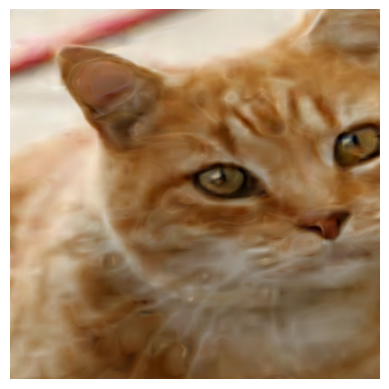

In [57]:
rgb= eval_image(mrhe, img.shape[2], img.shape[3], idx=0, num_levels=3)

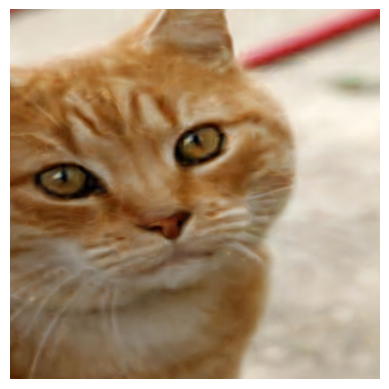

In [58]:
rgb = eval_image(mrhe, img.shape[2], img.shape[3], idx=1, num_levels=4)

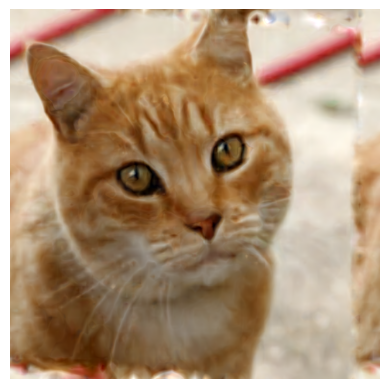

In [59]:
rgb = eval_image(mrhe, img.shape[2], img.shape[3], idx=None, num_levels=4)